In [1]:
import spacy
import nltk.data
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, BucketIterator
from torchtext import data
from collections import Counter
import spacy
import numpy as np
import re
import random
import math
import time
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
MIN_LEN = 5
MAX_LEN = 30

TRAIN_SIZE = 0.9
DEV_SIZE = 0.1
RANDOM_STATE = 101

In [3]:
authors=['Hemingway','Nietzsche','Wilde']
PATH = "/home/julia/PycharmProjects/seq2seq/books/"
books=[]
nlp = spacy.load('en')

In [7]:
def file_open(path):
    #Remove special characters
    with open(path, encoding='utf-8') as f:
        text = f.read()
        text = re.sub(r'([^a-záéíóúÁÉÍÓÚüA-Z0-9,.:?!¡¿ ])', '', text)
        return text

In [8]:
def convert_sentences(text):
    file_doc = nlp(text)
    sentences = list(file_doc.sents)
    filtered_sentences=[]
    for sent in sentences:
        if len(sent)>=MIN_LEN:
            filtered_sentences.append(sent)
    print("Total oraciones: ",len(sentences))
    print("Oraciones filtradas por longitud: ",len(filtered_sentences))
    return filtered_sentences

In [9]:
len(sents)

NameError: name 'sents' is not defined

In [ ]:
sents_by_author=[]
for author in authors:
    name_file = PATH + author
    print(name_file)
    books_author = []
    sents = []
    for file in glob.glob(name_file + "/*.txt"):
        books_author.append(file)
        txt = file_open(file)
        #Las oraciones se filtran por longitud, mínima 10
        sents = sents+convert_sentences(txt)
    sents_by_author.append(sents)
    #print(books_author)
    books.append(books_author)

In [ ]:
data_frames={}
d={}

In [ ]:
df=["df_{n_author}".format(n_author=a) for a in authors]
df

In [ ]:
for i in range(len(authors)):
    d["dataset_dict_{n_author}".format(n_author=authors[i])] = {'input': [sent for sent in sents_by_author[i]], 'output': [sent for sent in sents_by_author[i]]}

In [ ]:
df_Hemingway= pd.DataFrame(d["dataset_dict_Hemingway"],columns=["input", 'output'])
df_Nietzsche= pd.DataFrame(d["dataset_dict_Nietzsche"],columns=["input", 'output'])
df_Wilde = pd.DataFrame(d["dataset_dict_Wilde"],columns=["input", 'output'])

In [ ]:
data_frames = {df[0]:df_Hemingway,df[1]:df_Nietzsche,df[2]:df_Wilde}

In [ ]:
for i in range(len(authors)):
    train_df, test_df = train_test_split(data_frames[df[i]],
                                         test_size=DEV_SIZE,
                                         train_size=TRAIN_SIZE,
                                         random_state=69,
                                         shuffle=True)
    train_df.to_csv(PATH + "/" + authors[i] + "/datasets/trainset_"+authors[i]+".csv", index=False)
    test_df.to_csv(PATH + "/" + authors[i] + "/datasets/testset_"+authors[i]+".csv", index=False)

# Preparación de datos

In [4]:
def tokenize_output(text):
    return [tok.text for tok in nlp.tokenizer(text)]

In [5]:
def tokenize_input(text):
    return [tok.text for tok in nlp.tokenizer(text)][::-1]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


#Fields
SRC = Field(tokenize = tokenize_input,
            init_token = '<sos>',
            eos_token = '<eos>',
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False)

TRG_H = TRG_N = TRG_W = Field(tokenize = tokenize_output,
            init_token = '<sos>',
            eos_token = '<eos>',
            dtype = torch.long,
            lower = True,
            include_lengths = False,
            batch_first = False)

cuda


In [7]:
fields_h = [('src', SRC), ('trg_h', TRG_H)]
fields_n = [('src', SRC), ('trg_n', TRG_N)]
fields_w = [('src', SRC), ('trg_w', TRG_W)]

In [8]:
train_set_H, test_set_H = data.TabularDataset.splits(path=PATH+'/'+authors[0]+'/datasets/',
                                                train = 'trainset_'+authors[0]+'.csv',
                                                validation = 'testset_'+authors[0]+'.csv',
                                                format='csv',
                                                fields=fields_h,
                                                skip_header=True)

In [9]:
train_set_N, test_set_N = data.TabularDataset.splits(path=PATH+'/'+authors[1]+'/datasets/',
                                                train = 'trainset_'+authors[1]+'.csv',
                                                validation = 'testset_'+authors[1]+'.csv',
                                                format='csv',
                                                fields=fields_n,
                                                skip_header=True)

In [10]:
train_set_W, test_set_W = data.TabularDataset.splits(path=PATH+'/'+authors[2]+'/datasets/',
                                                train = 'trainset_'+authors[2]+'.csv',
                                                validation = 'testset_'+authors[2]+'.csv',
                                                format='csv',
                                                fields=fields_w,
                                                skip_header=True)

In [11]:
print(f'\t Hemingway: len(train_set): {len(train_set_H)}')
print(f'\t Hemingway: len(dev_set): {len(test_set_H)}')
print(f'\t Nietzsche: len(train_set): {len(train_set_N)}')
print(f'\t Nietzsche: len(dev_set): {len(test_set_N)}')
print(f'\t Wilde: len(train_set): {len(train_set_W)}')
print(f'\t Wilde: len(dev_set): {len(test_set_W)}')

	 Hemingway: len(train_set): 28725
	 Hemingway: len(dev_set): 3192
	 Nietzsche: len(train_set): 14451
	 Nietzsche: len(dev_set): 1606
	 Wilde: len(train_set): 15687
	 Wilde: len(dev_set): 1743


In [12]:
#Solo un encoder
SRC.build_vocab(train_set_H, train_set_N, train_set_W,
                         #dev_set,
                         max_size = None,
                         min_freq = 2,
                         vectors = "glove.6B.300d")

In [13]:
TRG_H.build_vocab(train_set_H,
                         #dev_set,
                         max_size = None,
                         min_freq = 2,
                         vectors = "glove.6B.300d")
TRG_N.build_vocab(train_set_N,
                         #dev_set,
                         max_size = None,
                         min_freq = 2,
                         vectors = "glove.6B.300d")
TRG_W.build_vocab(train_set_W,
                         #dev_set,
                         max_size = None,
                         min_freq = 2,
                         vectors = "glove.6B.300d")


In [14]:
print("Vocabulary Encoder Matrix: ",SRC.vocab.vectors.shape)
print("Vocabulary Decoder Hemingway Matrix: ",TRG_H.vocab.vectors.shape)
print("Vocabulary Decoder Netzsche Matrix: ",TRG_N.vocab.vectors.shape)
print("Vocabulary Decoder Wilde Matrix: ",TRG_W.vocab.vectors.shape)

Vocabulary Encoder Matrix:  torch.Size([13726, 300])
Vocabulary Decoder Hemingway Matrix:  torch.Size([5868, 300])
Vocabulary Decoder Netzsche Matrix:  torch.Size([5868, 300])
Vocabulary Decoder Wilde Matrix:  torch.Size([5868, 300])



# Creación del modelo 

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, emb_mat, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.emb_mat = emb_mat
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)
        self.embedding.weight.data.copy_(emb_mat) #matrix precargada
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first = False, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)

        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # outputs are always from the top hidden layer

        return outputs, (hidden, cell)

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim,emb_mat, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.emb_mat = emb_mat
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding.weight.data.copy_(emb_mat)  # load pretrained embedding matrix
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers,batch_first = False, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)



    def forward(self, input, state):
        (hidden, cell) = state
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]

        #input = input.unsqueeze(0)

        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))

        # embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        output = self.dropout(output)
        prediction = self.fc_out(output.squeeze(0))

        # prediction = [batch size, output dim]

        return prediction, (hidden, cell)


In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoders):
        super().__init__()

        self.encoder = encoder
        self.decoder_H = decoders[0]
        self.decoder_N = decoders[1]
        self.decoder_W = decoders[2]

        
    def forward(self, src, trg, index_author,teacher_forcing_ratio):
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        if index_author == 0:            
            decoder = self.decoder_H
        elif index_author == 1:
            decoder = self.decoder_N
        elif index_author == 2:
            decoder = self.decoder_W
        
        
        
        #batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = decoder.output_dim

        # tensor to store decoder outputs
        #outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        output,(hidden, cell) = self.encoder(src)
        
        batch_output = F.one_hot(trg[0:1], num_classes=trg_vocab_size).float()

        # first input to the decoder is the <sos> tokens
        #input = trg[0, :]

        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states
            if t == 1:
                trg_t  = trg[t-1:t] #ie: <sos>
            else:
                if torch.rand(1) < teacher_forcing_ratio:
                    trg_t = trg[t-1:t]
                else:
                        # output_t: [trg_len=1, batch_size, trg_vocab_size]
                    trg_t = output_t.argmax(2)
            
            
            # receive output tensor (predictions) and new hidden and cell states
            output_t, (hidden, cell) = decoder(trg_t, (hidden, cell))
            
            output_t = output_t.unsqueeze(0)
                # output_t: [trg_len=1, batch_size, trg_vocab_size]
            
            batch_output = torch.cat((batch_output, output_t), 0)
            
            # place predictions in a tensor holding predictions for each token
            #outputs[t] = output

            # decide if we are going to use teacher forcing or not
            #teacher_force = random.random() < teacher_forcing_ratio

            # get the highest predicted token from our predictions
            #top1 = output.argmax(1)

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            #input = trg[t] if teacher_force else top1

        return batch_output

In [28]:
#Encoder
INPUT_DIM = len(SRC.vocab)
ENC_EMB_DIM =  SRC.vocab.vectors.shape[1]
ENC_EMB_MAT = SRC.vocab.vectors
ENC_HID_DIM = 512
ENC_N_LAYERS = 4
ENC_DROPOUT = 0.5

#decoders General
DEC_EMB_DIM = 256
DEC_HID_DIM = 512
DEC_N_LAYERS = 4
DEC_DROPOUT = 0.5

#Decoder Hemingway
OUTPUT_DIMS_H = len(TRG_H.vocab)
DEC_EMB_DIM_H = TRG_H.vocab.vectors.shape[1]
DEC_EMB_MAT_H = TRG_H.vocab.vectors

#Decoder Nietzsche
OUTPUT_DIMS_N = len(TRG_N.vocab)
DEC_EMB_DIM_N = TRG_N.vocab.vectors.shape[1]
DEC_EMB_MAT_N = TRG_N.vocab.vectors

#Decoder Wilde
OUTPUT_DIMS_W = len(TRG_W.vocab)
DEC_EMB_DIM_W = TRG_W.vocab.vectors.shape[1]
DEC_EMB_MAT_W = TRG_W.vocab.vectors

TRG_OUTPUT_DIM = [OUTPUT_DIMS_H, OUTPUT_DIMS_N, OUTPUT_DIMS_W]
DEC_EMB_DIM = [DEC_EMB_DIM_H, DEC_EMB_DIM_N, DEC_EMB_DIM_W]
DEC_EMB_MAT = [DEC_EMB_MAT_H, DEC_EMB_MAT_N, DEC_EMB_MAT_W]


BATCH_SIZE = 4
LEARNING_RATE = 0.001
N_EPOCHS = 100
CLIP = 1

p = 1.0 
min_prob = 0.01
linear_decay = 0.00125

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
train_iterator_H, test_iterator_H = BucketIterator.splits(
                                    (train_set_H,  test_set_H),
                                    batch_size = BATCH_SIZE,
                                    sort_key = lambda x: len(x.src),
                                    device = device,
                                    shuffle = True)

train_iterator_N, test_iterator_N = BucketIterator.splits(
                                    (train_set_N,  test_set_N),
                                    batch_size = BATCH_SIZE,
                                    sort_key = lambda x: len(x.src),
                                    device = device,
                                    shuffle = True)

train_iterator_W, test_iterator_W = BucketIterator.splits(
                                    (train_set_W,  test_set_W),
                                    batch_size = BATCH_SIZE,
                                    sort_key = lambda x: len(x.src),
                                    device = device,
                                    shuffle = True)
train_iterator=[train_iterator_H,train_iterator_N,train_iterator_W]
test_iterator=[test_iterator_H, test_iterator_N, test_iterator_W]

In [21]:
def inicialize_model(input_dim,input_emb_dim, input_emb_mat, input_hid_dim, input_n_layers, input_dropout, output_dim,output_emb_dim, output_emb_mat, output_hid_dim, output_n_layers, output_dropout):
    enc = Encoder(input_dim=input_dim, 
                  emb_dim=input_emb_dim, 
                  emb_mat=input_emb_mat, 
                  hid_dim=input_hid_dim, 
                  n_layers=input_n_layers, 
                  dropout=input_dropout)
                     
    dec_h = Decoder(output_dim = output_dim[0],
                    emb_dim = output_emb_dim[0], 
                    emb_mat = output_emb_mat[0], 
                    hid_dim = output_hid_dim, 
                    n_layers = output_n_layers, 
                    dropout = output_dropout)
    
    dec_n = Decoder(output_dim = output_dim[1],
                    emb_dim = output_emb_dim[1], 
                    emb_mat = output_emb_mat[1], 
                    hid_dim = output_hid_dim, 
                    n_layers = output_n_layers, 
                    dropout = output_dropout)
    
    dec_w = Decoder(output_dim = output_dim[2],
                    emb_dim = output_emb_dim[2], 
                    emb_mat = output_emb_mat[2], 
                    hid_dim = output_hid_dim, 
                    n_layers = output_n_layers, 
                    dropout = output_dropout)
    
    decoders=[dec_h,dec_n,dec_w]
    model  = Seq2Seq(enc, decoders)
    
    return model
    
    

In [22]:
model = inicialize_model(INPUT_DIM,
                         ENC_EMB_DIM, 
                         ENC_EMB_MAT, 
                         ENC_HID_DIM, 
                         ENC_N_LAYERS, 
                         ENC_DROPOUT, 
                         TRG_OUTPUT_DIM,
                         DEC_EMB_DIM, 
                         DEC_EMB_MAT, 
                         DEC_HID_DIM, 
                         DEC_N_LAYERS, 
                         DEC_DROPOUT
                         )

model = model.to(device)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 50,313,116 trainable parameters


# Parámetros

In [24]:
optimizer = optim.Adam(params=model.parameters(),lr = LEARNING_RATE)

#decoder Hemingway
TRG_PAD_IDX_H = TRG_H.vocab.stoi['<pad>']
criterion_H = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX_H)

#dec Niezsche
TRG_PAD_IDX_N = TRG_N.vocab.stoi['<pad>']
criterion_N = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX_N)

#dec Wilde
TRG_PAD_IDX_W = TRG_W.vocab.stoi['<pad>']
criterion_W = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX_W)

criterion=[criterion_H, criterion_N, criterion_W]

# Entrenar modelo

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
def train(model, iterator,teacher_forcing_ratio, optimizer, criterion, clip,training=True):
    if training:
        model.train()
    else:
        model.eval()
        
    epoch_loss = 0
    loss_sum = 0
    
    author_index = [0]*len(iterator[0]) + [1]*len(iterator[1]) + [2]*len(iterator[2])
    author_permutation = random.sample(author_index, len(author_index))
    
    for author in author_permutation:
        if author==0: #Hemingway
            batch = next(iter(iterator[0]))
            src = batch.src
            trg = batch.trg_h
        elif author==1: #Niezsche
            batch = next(iter(iterator[1]))
            src = batch.src
            trg = batch.trg_n
        elif author==2: #Wilde
            batch = next(iter(iterator[2]))
            src = batch.src
            trg = batch.trg_w
        
        src = src.to(device) 
        trg = trg.to(device) 
        output = model(src = src, 
                       trg = trg, 
                       index_author = author,
                       teacher_forcing_ratio = teacher_forcing_ratio)    
    
       
        output = output[1:]
        trg = trg[1:]
        
        loss = criterion[author](output.view(-1, output.shape[2]), trg.view(-1))

        if training:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

  
        loss_sum += loss.item()
        #acc_sum += acc.item()

    epoch_loss = loss_sum / len(author_permutation)
    #epoch_acc = acc_sum / len(iterator)
    return epoch_loss

In [29]:
print('\nTraining:')
train_loss_epoch = []
dev_loss_epoch = []
best_dev_loss = float('inf')
for epoch in range(N_EPOCHS):
    
    # Schedule teacher forcing
    p = max(min_prob, (p - linear_decay)) 
    
    start_time = time.time()
    
    train_loss = train(model = model,
                       iterator = train_iterator,
                       teacher_forcing_ratio = p,
                       optimizer = optimizer,
                       criterion =  criterion,
                       clip = CLIP,
                       training = True)
    with torch.no_grad():
        dev_loss = train(model = model,
                       iterator = test_iterator,
                       teacher_forcing_ratio = 0,
                       optimizer = None,
                       criterion =  criterion,
                       clip = None,
                       training = False)

    train_loss_epoch.append(train_loss)
    dev_loss_epoch.append(dev_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), 'model_100.pt')
    print('-' * 89)
    print(f'Epoch: {epoch+1:03} | Time: {epoch_mins}m {epoch_secs}s | TFprob: {p:.4f} | Train loss: {train_loss:.4f} | | Dev loss: {dev_loss:.4f}')
print('-' * 89)


Training:
-----------------------------------------------------------------------------------------
Epoch: 001 | Time: 48m 45s | TFprob: 0.9988 | Train loss: 3.4697 | | Dev loss: 2.3570
-----------------------------------------------------------------------------------------
Epoch: 002 | Time: 48m 33s | TFprob: 0.9975 | Train loss: 3.4197 | | Dev loss: 2.7840
-----------------------------------------------------------------------------------------
Epoch: 003 | Time: 49m 2s | TFprob: 0.9963 | Train loss: 3.3861 | | Dev loss: 2.9996
-----------------------------------------------------------------------------------------
Epoch: 004 | Time: 48m 36s | TFprob: 0.9950 | Train loss: 3.3350 | | Dev loss: 2.1791
-----------------------------------------------------------------------------------------
Epoch: 005 | Time: 50m 46s | TFprob: 0.9938 | Train loss: 3.3067 | | Dev loss: 2.2223
-----------------------------------------------------------------------------------------
Epoch: 006 | Time: 5

-----------------------------------------------------------------------------------------
Epoch: 048 | Time: 49m 20s | TFprob: 0.9400 | Train loss: 2.7960 | | Dev loss: 1.5210
-----------------------------------------------------------------------------------------
Epoch: 049 | Time: 49m 17s | TFprob: 0.9388 | Train loss: 2.7788 | | Dev loss: 1.8023
-----------------------------------------------------------------------------------------
Epoch: 050 | Time: 49m 16s | TFprob: 0.9375 | Train loss: 2.7848 | | Dev loss: 1.6156
-----------------------------------------------------------------------------------------
Epoch: 051 | Time: 49m 17s | TFprob: 0.9363 | Train loss: 2.7825 | | Dev loss: 1.6416
-----------------------------------------------------------------------------------------
Epoch: 052 | Time: 49m 11s | TFprob: 0.9350 | Train loss: 2.7751 | | Dev loss: 1.5570
-----------------------------------------------------------------------------------------
Epoch: 053 | Time: 49m 22s | T

-----------------------------------------------------------------------------------------
Epoch: 095 | Time: 49m 35s | TFprob: 0.8813 | Train loss: 2.7453 | | Dev loss: 1.7031
-----------------------------------------------------------------------------------------
Epoch: 096 | Time: 49m 37s | TFprob: 0.8800 | Train loss: 2.7367 | | Dev loss: 1.5807
-----------------------------------------------------------------------------------------
Epoch: 097 | Time: 49m 40s | TFprob: 0.8788 | Train loss: 2.7365 | | Dev loss: 1.5185
-----------------------------------------------------------------------------------------
Epoch: 098 | Time: 49m 48s | TFprob: 0.8775 | Train loss: 2.7495 | | Dev loss: 1.6196
-----------------------------------------------------------------------------------------
Epoch: 099 | Time: 49m 45s | TFprob: 0.8763 | Train loss: 2.7457 | | Dev loss: 1.4807
-----------------------------------------------------------------------------------------
Epoch: 100 | Time: 49m 51s | T

In [31]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epoch')

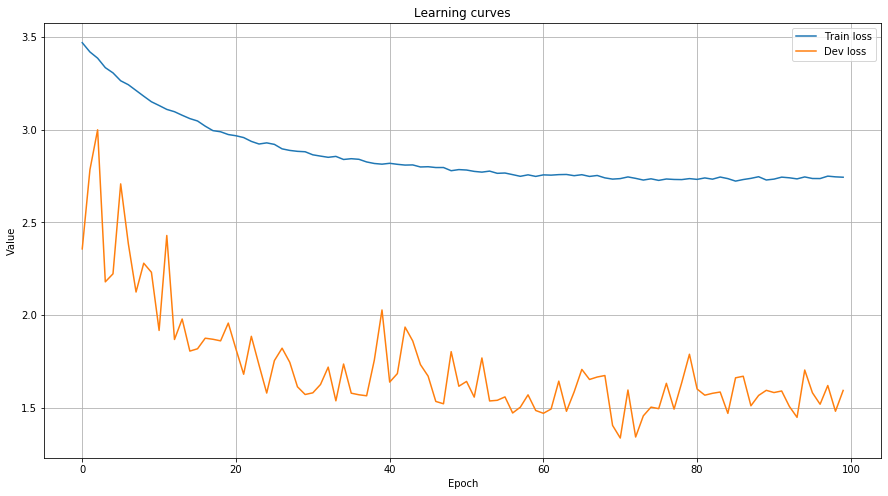

In [32]:
plt.figure(figsize=(15,8))
plt.grid(b=True)
plt.plot(train_loss_epoch, label='Train loss')
plt.plot(dev_loss_epoch, label='Dev loss')
plt.title('Learning curves')
plt.legend()
plt.ylabel('Value')
plt.xlabel('Epoch')

# Predicciones

In [4]:
model.load_state_dict(torch.load('model_100.pt'))
model.eval()

NameError: name 'model' is not defined